In [115]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from modelling_functions import (
    LSTMModel,
    LinearModel,
    prepare_dataloaders,
    load_and_preprocess_data,
    evaluate_anomalies,
    load_data,
)


from eda_helper import (
    get_custom_palette,
    get_custom_heatmap,
    get_custom_colormap,
    plot_mv_windows,
    preprocess_data,
    extract_values_from_filename,
)

custom_palette = get_custom_palette()
custom_heatmap = get_custom_heatmap()
custom_colormap = get_custom_colormap()

print(os.getcwd())

completeness_code = 10989694

completeness_value = 0.5
error_deviations = 5
VARIATE = "Multivariate"

input_feature_indices = list(range(0, 11)) if "Multivariate" else [0]
target_feature_index = 0
horizon = 6
window_size = 48
batch_size = 1
stride = 1
device = "cpu"

c:\#code\#python\#current\mres-project\analysis_files


In [116]:
# east_df, west_df = load_data()
# east_dict = preprocess_data(east_df, completeness_value)
# west_dict = preprocess_data(east_df, completeness_value)

# data, columns, index = east_dict["data"], east_dict["columns"], east_dict["index"]
# plt.figure(figsize=(5, 5))
# plt.hist(data[:, 0], bins=100, color=custom_palette[0])
# plt.xlabel("Scaled value (pedestrian flow)")
# plt.ylabel("Frequency")
# plt.title("East Sensor")
# data, columns, index = west_dict["data"], west_dict["columns"], west_dict["index"]
# plt.figure(figsize=(5, 5))
# plt.hist(data[:, 0], bins=100, color=custom_palette[1])
# plt.xlabel("Scaled value (pedestrian flow)")
# plt.ylabel("Frequency")
# plt.title("West Sensor")

In [117]:
east_timeseries = load_and_preprocess_data(completeness_value)
data = east_timeseries

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 50% completeness: 39072
Proportion of records removed: 2.09%
Maximum consecutive days: 89
Starting from day number 1 in 2023


In [118]:
(
    train_dataloader,
    test_dataloader,
    test_inputs,
    test_targets,
    train_inputs,
    train_targets,
) = prepare_dataloaders(
    data=data,
    window_size=window_size,
    input_feature_indices=input_feature_indices,
    target_feature_index=target_feature_index,
    horizon=horizon,
    stride=stride,
    batch_size=batch_size,
    shuffle=False,
)

In [119]:
for X, y in train_dataloader:
    X = X.float().to("cpu")
    y = y.float().to("cpu")
    print(X.shape)
    print(y.shape)
    break

torch.Size([1, 48, 11])
torch.Size([1])


In [121]:
def load_model_with_state_dict(model_file_path, input_feature_indices):
    if "Linear" in model_file_path:
        model = LinearModel(input_size=len(input_feature_indices))
    else:
        model = LSTMModel(feature_dim=len(input_feature_indices))

    model.load_state_dict(torch.load(model_file_path))
    model.to(device)
    return model


# Define the base file patterns
completeness_values = {"mv": "0.94", "uv": "0.98"}
sequence_lengths = {"mv": "9050", "uv": "2776"}

data_type = "mv" if len(input_feature_indices) > 1 else "uv"
model_folder_path = f"C:\\#code\\#python\\#current\\mres-project\\analysis_files\\{data_type}_model_states\\c10989694\\"

lstm_model_pattern = os.path.join(
    model_folder_path,
    f"*Completeness{completeness_values[data_type]}_SequenceLength{sequence_lengths[data_type]}_Horizon6_WindowSize{window_size}.pt",
)
linear_model_pattern = os.path.join(
    model_folder_path,
    f"*Completeness{completeness_values[data_type]}_SequenceLength{sequence_lengths[data_type]}_Horizon6_WindowSize1.pt",
)
print(linear_model_pattern)
print(lstm_model_pattern)

# Use glob to find the correct model file paths
lstm_model_path = glob.glob(lstm_model_pattern)[0]  # Assuming only one matching file
linear_model_path = glob.glob(linear_model_pattern)[
    0
]  # Assuming only one matching file

lstm_values = extract_values_from_filename(lstm_model_path)

linear_values = extract_values_from_filename(linear_model_path)

print(lstm_values, linear_values)
(
    sequence_length_value,
    horizon_value,
    lstm_window_size_value,
    model_completeness_value,
    test_number,
) = [
    lstm_values[key]
    for key in ["SequenceLength", "Horizon", "WindowSize", "Completeness", "TestNumber"]
]

# Load LSTM Model
lstm_model = load_model_with_state_dict(lstm_model_path, input_feature_indices)
(
    sequence_length_value,
    horizon_value,
    linear_window_size_value,
    model_completeness_value,
    test_number,
) = [
    linear_values[key]
    for key in ["SequenceLength", "Horizon", "WindowSize", "Completeness", "TestNumber"]
]

# Load Linear Model (if necessary, you can uncomment this line)
linear_model = load_model_with_state_dict(linear_model_path, input_feature_indices)

SyntaxError: cannot assign to function call (542448871.py, line 57)

In [ ]:
window_size_value

1

6801 6801 6801
(3, 48, 7) (3,) (3, 1)


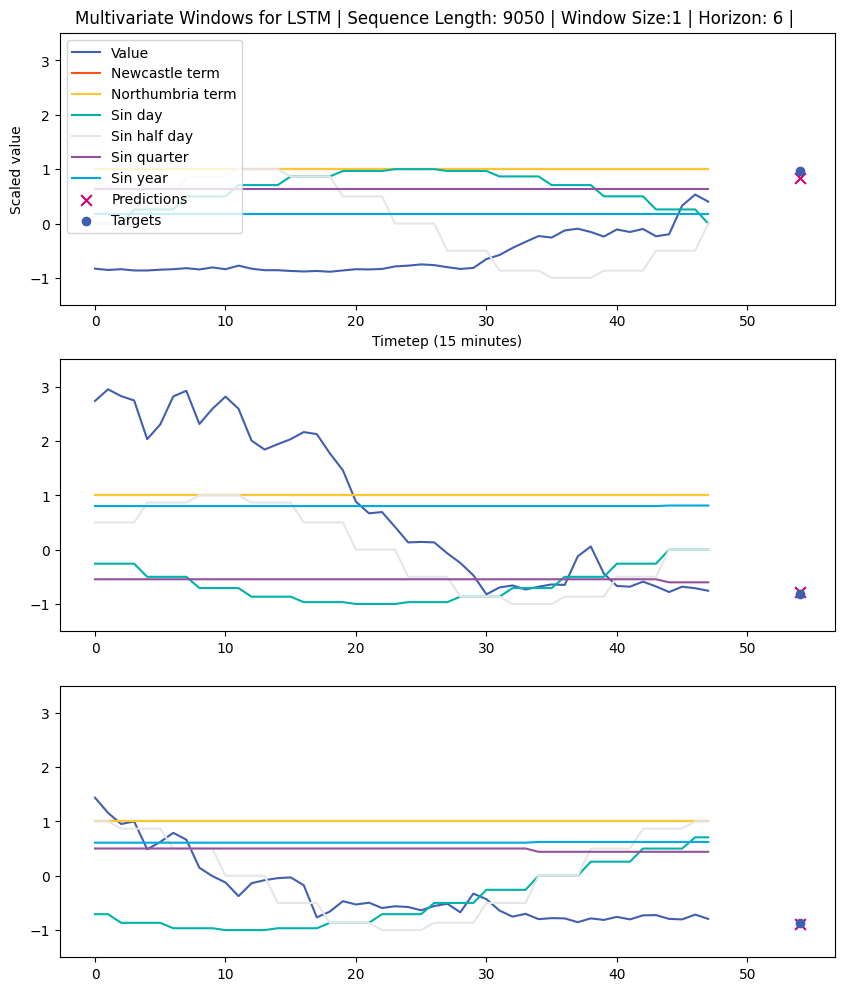

In [ ]:
MODEL = "LSTM"

model = linear_model if MODEL == "Linear" else lstm_model


feature_names = [
    "Value",
    "Newcastle term",
    "Northumbria term",
    "Sin day",
    "Cos day",
    "Sin half day",
    "Cos half day",
    "Sin quarter",
    "Cos quarter",
    "Sin year",
    "Cos year",
]

num_plots = 3

# First, gather all the data from the DataLoader
all_inputs = []
all_targets = []
all_predictions = []

for X, y in train_dataloader:
    X = X.float().to(device)
    with torch.inference_mode():
        if MODEL == "Linear":
            y_hat = model(X[:, -1, :].unsqueeze(1))
            # print("Linear Model Found")
        else:
            # print("LSTM Model Found")
            y_hat = model(X)
    X = (
        X[:, :, [0, 1, 2, 3, 5, 7, 9]] if len(input_feature_indices) > 1 else X
    )  # Handle MV and UV
    all_inputs.extend(X.numpy())
    all_targets.extend(y.numpy())
    all_predictions.extend(y_hat.numpy())

print(len(all_inputs), len(all_targets), len(all_predictions))

# Convert lists to numpy arrays
all_inputs = np.array(all_inputs)
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)
feature_names = (
    [feature_names[i] for i in [0, 1, 2, 3, 5, 7, 9]]
    if len(input_feature_indices) > 1
    else ["Value"]
)

# Ensure we have enough data
if len(all_inputs) < num_plots:
    raise ValueError(
        f"Data size should be at least {num_plots} but got {len(all_inputs)}"
    )

# Randomly sample `num_plots` windows and targets
random_indices = np.random.choice(len(all_inputs), num_plots, replace=False)
selected_inputs = all_inputs[random_indices]
selected_targets = all_targets[random_indices]
selected_predictions = all_predictions[random_indices]

title = f"{VARIATE} Windows for {MODEL} | Sequence Length: {sequence_length_value} | Window Size:{window_size_value} | Horizon: {horizon_value} |"

# Now use the selected windows and targets in the plot_mv_windows function
plot_mv_windows(
    selected_inputs,
    selected_targets,  # Assuming predictions are same as targets for now
    selected_predictions,
    horizon=horizon,
    num_plots=num_plots,
    input_feature_names=feature_names,
    title=title,
)

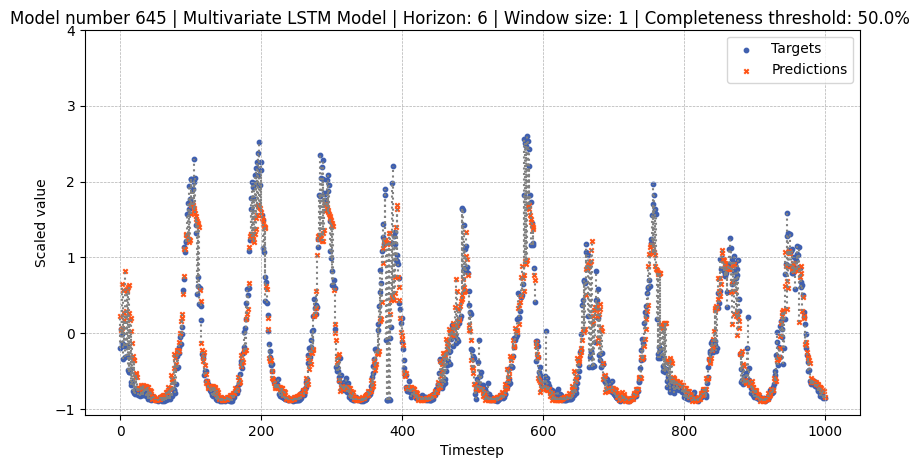

In [ ]:
MODEL = MODEL

predictions = all_predictions
targets = all_targets
inputs = all_inputs

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(
    f"Model number {test_number} | {VARIATE} {MODEL} Model | Horizon: {horizon_value} | Window size: {window_size_value} | Completeness threshold: {completeness_value*100}%",
    y=0.92,
)

ax.scatter(
    list(range(len(targets)))[:1000],
    targets[:1000],
    label="Targets",
    s=10,
    marker="o",
    color=custom_palette[0],
)
ax.scatter(
    list(range(len(targets)))[:1000],
    predictions[:1000],
    label="Predictions",
    s=10,
    marker="x",
    color=custom_palette[1],
)

# Add vertical lines
for i in range(len(targets))[:1000]:
    ax.vlines(
        x=i,
        ymin=min(targets[i], predictions[i]),
        ymax=max(targets[i], predictions[i]),
        colors="gray",
        linestyles="dotted",
    )
ax.set_xlabel("Timestep")
ax.set_ylabel("Scaled value")
ax.set_yticks(np.arange(-1, 5, 1))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

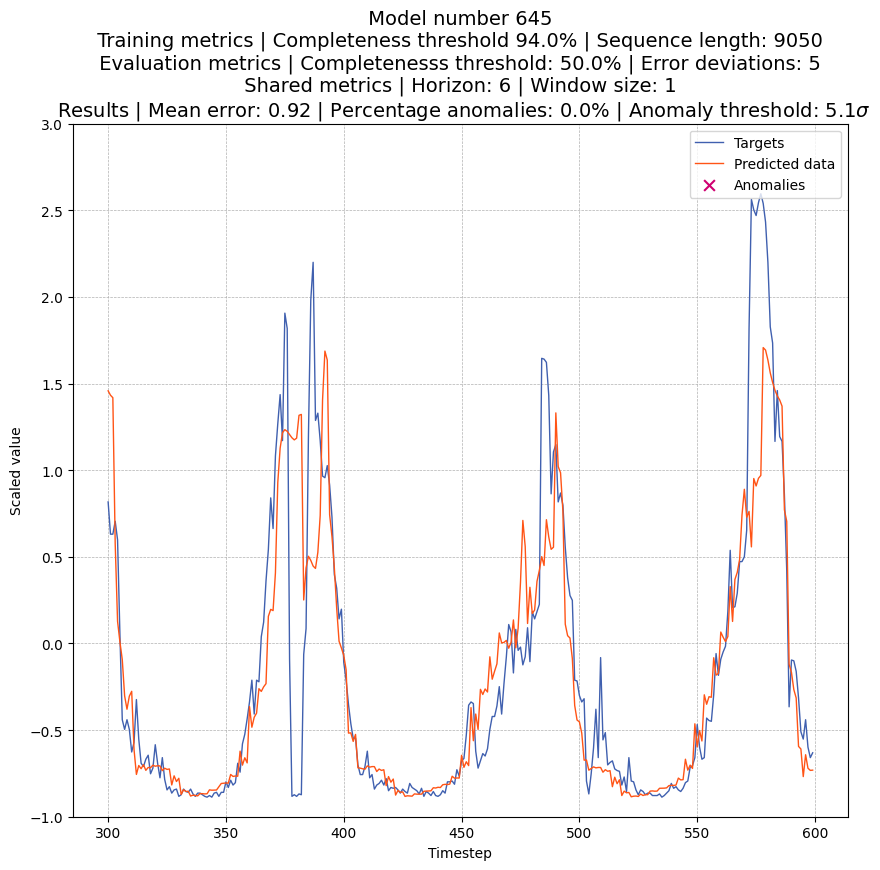

In [ ]:
# Plotting the second graph
errors = np.abs(predictions - targets)

anomaly_threshold = np.round(errors.mean() + error_deviations * errors.std(), 1)
anomalies = errors > anomaly_threshold

# Count total anomalies
total_anomalies = np.sum(anomalies)

anomaly_percentage = (total_anomalies / len(targets)) * 100

# Create time vector
time = np.arange(len(train_inputs))

# Find the indices of all anomalies
anomaly_indices = np.where(anomalies)[0]

# Define t1 and t2
t1, t2 = 300, 600

# Filter those indices to only consider the [t1:t2] range
filtered_anomaly_indices = anomaly_indices[
    (anomaly_indices >= t1) & (anomaly_indices < t2)
]

# Use these filtered indices to get the anomaly_times and anomaly_values
anomaly_times = time[filtered_anomaly_indices]
anomaly_values = targets[filtered_anomaly_indices]

fig, ax = plt.subplots(figsize=(10, 9))
# Plot the time series
ax.plot(
    time[t1:t2],
    targets[t1:t2],
    label="Targets",
    linewidth=1,
    color=custom_palette[0],
)
ax.plot(
    time[t1:t2],
    predictions[t1:t2],
    linewidth=1,
    label="Predicted data",
    color=custom_palette[1],
)

# Mark the anomalies
ax.scatter(
    anomaly_times,
    anomaly_values,
    label="Anomalies",
    color=custom_palette[7],
    marker="x",
    s=60,
    zorder=3,
)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_ylim(-1, 3)
ax.set_ylabel("Scaled value")
ax.set_xlabel("Timestep")
ax.set_title(
    f" Model number {test_number} \n Training metrics | Completeness threshold {model_completeness_value*100}% | Sequence length: {sequence_length_value} \n Evaluation metrics | Completenesss threshold: {completeness_value * 100}% | Error deviations: {error_deviations} \n Shared metrics | Horizon: {horizon_value} | Window size: {window_size_value} \n Results | Mean error: {errors.mean():.2f} | Percentage anomalies: {(total_anomalies/sequence_length_value*100):.1f}% | Anomaly threshold: {anomaly_threshold}$\sigma$",
    fontsize=14,
)
ax.legend(loc="upper right")